# Image Features
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [1]:
import random
import numpy as np
from exercise_code.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk. However, we don't apply our previous preprocessing steps, as we want to extract custom features later on.

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


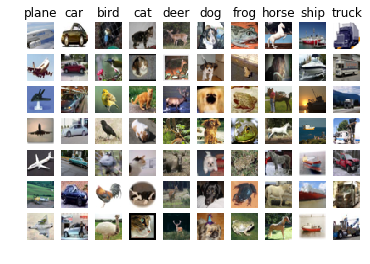

In [2]:
from exercise_code.data_utils import load_CIFAR10
from exercise_code.vis_utils import visualize_cifar10

def get_CIFAR10_data(num_training=48000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for feature extraction and training.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/'
    X, y = load_CIFAR10(cifar10_dir)
    

    # Our training set will be the first num_train points from the original
    # training set.
    mask = range(num_training)
    X_train = X[mask]
    y_train = y[mask]
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = range(num_training, num_training + num_validation)
    X_val = X[mask]
    y_val = y[mask]
    
    # We use a small subset of the training set as our test set.
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X[mask]
    y_test = y[mask]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
X_raw, y_raw, X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# visualize raw data
visualize_cifar10(X_raw, y_raw)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from exercise_code.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000/48000 images
Done extracting features for 2000/48000 images
Done extracting features for 3000/48000 images
Done extracting features for 4000/48000 images
Done extracting features for 5000/48000 images
Done extracting features for 6000/48000 images
Done extracting features for 7000/48000 images
Done extracting features for 8000/48000 images
Done extracting features for 9000/48000 images
Done extracting features for 10000/48000 images
Done extracting features for 11000/48000 images
Done extracting features for 12000/48000 images
Done extracting features for 13000/48000 images
Done extracting features for 14000/48000 images
Done extracting features for 15000/48000 images
Done extracting features for 16000/48000 images
Done extracting features for 17000/48000 images
Done extracting features for 18000/48000 images
Done extracting features for 19000/48000 images
Done extracting features for 20000/48000 images
Done extracting features for 21000/48000 images
D

## Train a Softmax classifier on features
Using the multiclass Softmax code developed earlier in the assignment, train a Softmax classifier on top of the features extracted above; this should achieve better results than training the classifier directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from exercise_code.classifiers.linear_classifier import SoftmaxClassifier
#softmax = SoftmaxClassifier()
learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_softmax = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. You might also want to play      #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        softmax = SoftmaxClassifier()
        loss_hist = softmax.train(X_train_feats, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=20000, verbose=True)
        y_train_pred = softmax.predict(X_train_feats)
        trainingAccuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % trainingAccuracy, )
        y_val_pred = softmax.predict(X_val_feats)
        validationAccuracy = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % validationAccuracy, )
        results[(learning_rate, reg)] = (trainingAccuracy, validationAccuracy)
        if validationAccuracy > best_val:
            best_val = validationAccuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
          lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

iteration 0 / 20000: loss 157.030835
iteration 100 / 20000: loss 150.965050
iteration 200 / 20000: loss 145.134218
iteration 300 / 20000: loss 139.533475
iteration 400 / 20000: loss 134.151869
iteration 500 / 20000: loss 128.979601
iteration 600 / 20000: loss 124.013903
iteration 700 / 20000: loss 119.240320
iteration 800 / 20000: loss 114.655365
iteration 900 / 20000: loss 110.248823
iteration 1000 / 20000: loss 106.016912
iteration 1100 / 20000: loss 101.948796
iteration 1200 / 20000: loss 98.040412
iteration 1300 / 20000: loss 94.287771
iteration 1400 / 20000: loss 90.680133
iteration 1500 / 20000: loss 87.215185
iteration 1600 / 20000: loss 83.884637
iteration 1700 / 20000: loss 80.684840
iteration 1800 / 20000: loss 77.611446
iteration 1900 / 20000: loss 74.658821
iteration 2000 / 20000: loss 71.820499
iteration 2100 / 20000: loss 69.094037
iteration 2200 / 20000: loss 66.475701
iteration 2300 / 20000: loss 63.959882
iteration 2400 / 20000: loss 61.540804
iteration 2500 / 20000: l

iteration 1300 / 20000: loss 10.806119
iteration 1400 / 20000: loss 8.000465
iteration 1500 / 20000: loss 6.120490
iteration 1600 / 20000: loss 4.860767
iteration 1700 / 20000: loss 4.016744
iteration 1800 / 20000: loss 3.451130
iteration 1900 / 20000: loss 3.072164
iteration 2000 / 20000: loss 2.818217
iteration 2100 / 20000: loss 2.648086
iteration 2200 / 20000: loss 2.534093
iteration 2300 / 20000: loss 2.457699
iteration 2400 / 20000: loss 2.406527
iteration 2500 / 20000: loss 2.372235
iteration 2600 / 20000: loss 2.349252
iteration 2700 / 20000: loss 2.333851
iteration 2800 / 20000: loss 2.323540
iteration 2900 / 20000: loss 2.316626
iteration 3000 / 20000: loss 2.311995
iteration 3100 / 20000: loss 2.308887
iteration 3200 / 20000: loss 2.306810
iteration 3300 / 20000: loss 2.305414
iteration 3400 / 20000: loss 2.304481
iteration 3500 / 20000: loss 2.303855
iteration 3600 / 20000: loss 2.303436
iteration 3700 / 20000: loss 2.303155
iteration 3800 / 20000: loss 2.302967
iteration 3

iteration 2600 / 20000: loss 2.302585
iteration 2700 / 20000: loss 2.302585
iteration 2800 / 20000: loss 2.302585
iteration 2900 / 20000: loss 2.302585
iteration 3000 / 20000: loss 2.302585
iteration 3100 / 20000: loss 2.302585
iteration 3200 / 20000: loss 2.302585
iteration 3300 / 20000: loss 2.302585
iteration 3400 / 20000: loss 2.302585
iteration 3500 / 20000: loss 2.302585
iteration 3600 / 20000: loss 2.302585
iteration 3700 / 20000: loss 2.302585
iteration 3800 / 20000: loss 2.302585
iteration 3900 / 20000: loss 2.302585
iteration 4000 / 20000: loss 2.302585
iteration 4100 / 20000: loss 2.302585
iteration 4200 / 20000: loss 2.302585
iteration 4300 / 20000: loss 2.302585
iteration 4400 / 20000: loss 2.302585
iteration 4500 / 20000: loss 2.302585
iteration 4600 / 20000: loss 2.302585
iteration 4700 / 20000: loss 2.302585
iteration 4800 / 20000: loss 2.302585
iteration 4900 / 20000: loss 2.302585
iteration 5000 / 20000: loss 2.302585
iteration 5100 / 20000: loss 2.302585
iteration 52

iteration 4100 / 20000: loss 2.302594
iteration 4200 / 20000: loss 2.302591
iteration 4300 / 20000: loss 2.302588
iteration 4400 / 20000: loss 2.302587
iteration 4500 / 20000: loss 2.302586
iteration 4600 / 20000: loss 2.302584
iteration 4700 / 20000: loss 2.302584
iteration 4800 / 20000: loss 2.302584
iteration 4900 / 20000: loss 2.302584
iteration 5000 / 20000: loss 2.302584
iteration 5100 / 20000: loss 2.302583
iteration 5200 / 20000: loss 2.302584
iteration 5300 / 20000: loss 2.302584
iteration 5400 / 20000: loss 2.302583
iteration 5500 / 20000: loss 2.302584
iteration 5600 / 20000: loss 2.302583
iteration 5700 / 20000: loss 2.302583
iteration 5800 / 20000: loss 2.302583
iteration 5900 / 20000: loss 2.302583
iteration 6000 / 20000: loss 2.302583
iteration 6100 / 20000: loss 2.302583
iteration 6200 / 20000: loss 2.302583
iteration 6300 / 20000: loss 2.302583
iteration 6400 / 20000: loss 2.302583
iteration 6500 / 20000: loss 2.302583
iteration 6600 / 20000: loss 2.302583
iteration 67

iteration 5300 / 20000: loss 2.302585
iteration 5400 / 20000: loss 2.302585
iteration 5500 / 20000: loss 2.302585
iteration 5600 / 20000: loss 2.302585
iteration 5700 / 20000: loss 2.302585
iteration 5800 / 20000: loss 2.302585
iteration 5900 / 20000: loss 2.302585
iteration 6000 / 20000: loss 2.302585
iteration 6100 / 20000: loss 2.302585
iteration 6200 / 20000: loss 2.302585
iteration 6300 / 20000: loss 2.302585
iteration 6400 / 20000: loss 2.302585
iteration 6500 / 20000: loss 2.302585
iteration 6600 / 20000: loss 2.302585
iteration 6700 / 20000: loss 2.302585
iteration 6800 / 20000: loss 2.302585
iteration 6900 / 20000: loss 2.302585
iteration 7000 / 20000: loss 2.302585
iteration 7100 / 20000: loss 2.302585
iteration 7200 / 20000: loss 2.302585
iteration 7300 / 20000: loss 2.302585
iteration 7400 / 20000: loss 2.302585
iteration 7500 / 20000: loss 2.302585
iteration 7600 / 20000: loss 2.302585
iteration 7700 / 20000: loss 2.302585
iteration 7800 / 20000: loss 2.302585
iteration 79

iteration 6700 / 20000: loss 2.302585
iteration 6800 / 20000: loss 2.302585
iteration 6900 / 20000: loss 2.302585
iteration 7000 / 20000: loss 2.302585
iteration 7100 / 20000: loss 2.302585
iteration 7200 / 20000: loss 2.302585
iteration 7300 / 20000: loss 2.302585
iteration 7400 / 20000: loss 2.302585
iteration 7500 / 20000: loss 2.302585
iteration 7600 / 20000: loss 2.302585
iteration 7700 / 20000: loss 2.302585
iteration 7800 / 20000: loss 2.302585
iteration 7900 / 20000: loss 2.302585
iteration 8000 / 20000: loss 2.302585
iteration 8100 / 20000: loss 2.302585
iteration 8200 / 20000: loss 2.302585
iteration 8300 / 20000: loss 2.302585
iteration 8400 / 20000: loss 2.302585
iteration 8500 / 20000: loss 2.302585
iteration 8600 / 20000: loss 2.302585
iteration 8700 / 20000: loss 2.302585
iteration 8800 / 20000: loss 2.302585
iteration 8900 / 20000: loss 2.302585
iteration 9000 / 20000: loss 2.302585
iteration 9100 / 20000: loss 2.302585
iteration 9200 / 20000: loss 2.302585
iteration 93

iteration 8400 / 20000: loss 2.302583
iteration 8500 / 20000: loss 2.302583
iteration 8600 / 20000: loss 2.302583
iteration 8700 / 20000: loss 2.302583
iteration 8800 / 20000: loss 2.302583
iteration 8900 / 20000: loss 2.302583
iteration 9000 / 20000: loss 2.302583
iteration 9100 / 20000: loss 2.302584
iteration 9200 / 20000: loss 2.302584
iteration 9300 / 20000: loss 2.302583
iteration 9400 / 20000: loss 2.302583
iteration 9500 / 20000: loss 2.302584
iteration 9600 / 20000: loss 2.302584
iteration 9700 / 20000: loss 2.302583
iteration 9800 / 20000: loss 2.302584
iteration 9900 / 20000: loss 2.302584
iteration 10000 / 20000: loss 2.302583
iteration 10100 / 20000: loss 2.302583
iteration 10200 / 20000: loss 2.302583
iteration 10300 / 20000: loss 2.302583
iteration 10400 / 20000: loss 2.302583
iteration 10500 / 20000: loss 2.302583
iteration 10600 / 20000: loss 2.302583
iteration 10700 / 20000: loss 2.302584
iteration 10800 / 20000: loss 2.302583
iteration 10900 / 20000: loss 2.302583
it

iteration 9700 / 20000: loss 2.302585
iteration 9800 / 20000: loss 2.302585
iteration 9900 / 20000: loss 2.302585
iteration 10000 / 20000: loss 2.302585
iteration 10100 / 20000: loss 2.302585
iteration 10200 / 20000: loss 2.302585
iteration 10300 / 20000: loss 2.302585
iteration 10400 / 20000: loss 2.302585
iteration 10500 / 20000: loss 2.302585
iteration 10600 / 20000: loss 2.302585
iteration 10700 / 20000: loss 2.302585
iteration 10800 / 20000: loss 2.302585
iteration 10900 / 20000: loss 2.302585
iteration 11000 / 20000: loss 2.302585
iteration 11100 / 20000: loss 2.302585
iteration 11200 / 20000: loss 2.302585
iteration 11300 / 20000: loss 2.302585
iteration 11400 / 20000: loss 2.302585
iteration 11500 / 20000: loss 2.302585
iteration 11600 / 20000: loss 2.302585
iteration 11700 / 20000: loss 2.302585
iteration 11800 / 20000: loss 2.302585
iteration 11900 / 20000: loss 2.302585
iteration 12000 / 20000: loss 2.302585
iteration 12100 / 20000: loss 2.302585
iteration 12200 / 20000: los

iteration 10000 / 20000: loss 16013.088030
iteration 10100 / 20000: loss 16013.109441
iteration 10200 / 20000: loss 16013.132243
iteration 10300 / 20000: loss 16013.177708
iteration 10400 / 20000: loss 16013.244679
iteration 10500 / 20000: loss 16013.244774
iteration 10600 / 20000: loss 16013.279857
iteration 10700 / 20000: loss 16013.329020
iteration 10800 / 20000: loss 16013.339792
iteration 10900 / 20000: loss 16013.359118
iteration 11000 / 20000: loss 16013.388629
iteration 11100 / 20000: loss 16013.426408
iteration 11200 / 20000: loss 16013.444587
iteration 11300 / 20000: loss 16013.468232
iteration 11400 / 20000: loss 16013.513615
iteration 11500 / 20000: loss 16013.554668
iteration 11600 / 20000: loss 16013.591437
iteration 11700 / 20000: loss 16013.635880
iteration 11800 / 20000: loss 16013.614039
iteration 11900 / 20000: loss 16013.608805
iteration 12000 / 20000: loss 16013.614007
iteration 12100 / 20000: loss 16013.645436
iteration 12200 / 20000: loss 16013.690944
iteration 1

In [5]:
# Evaluate your trained classifier on the test set
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.397


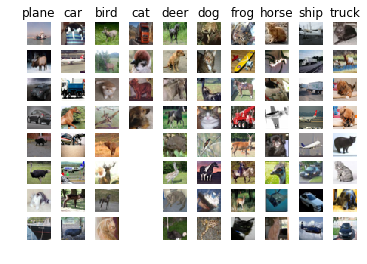

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    if len(idxs) > 0:
        idxs = np.random.choice(idxs, min(examples_per_class, len(idxs)), replace=False)
    else:
        idxs = []
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe the misclassification results that you see. Do they make sense?</p>
    <p>**Your answer:** 
Some of them make sense also for human intuition. For example, animals on green background are classified as deer, images that show sky as plane or trucks as cars.</p>
</div>

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set.

Note that in the neural net class we have used explicit biases. In the preprocessing of this exercise we have also added a bias dimension to the input, such that we don't have to consider an explicit bias in the linear classifier above. The neural net therefore has an additional parameter in the first layer (the additional bias term), which after all does not matter, as both bias terms can be learned. So just don't get confused by this.

In [7]:
from exercise_code.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# Train the network
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
num_iters=5000, batch_size=256,
learning_rate=0.9, learning_rate_decay=0.95,
reg=1e-3, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)

best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 5000: loss 2.302586
iteration 100 / 5000: loss 1.468325
iteration 200 / 5000: loss 1.356616
iteration 300 / 5000: loss 1.323116
iteration 400 / 5000: loss 1.321643
iteration 500 / 5000: loss 1.223703
iteration 600 / 5000: loss 1.398909
iteration 700 / 5000: loss 1.229678
iteration 800 / 5000: loss 1.264072
iteration 900 / 5000: loss 1.207283
iteration 1000 / 5000: loss 1.196513
iteration 1100 / 5000: loss 1.169173
iteration 1200 / 5000: loss 1.183818
iteration 1300 / 5000: loss 1.216944
iteration 1400 / 5000: loss 1.199862
iteration 1500 / 5000: loss 1.184105
iteration 1600 / 5000: loss 1.165438
iteration 1700 / 5000: loss 1.113024
iteration 1800 / 5000: loss 1.152536
iteration 1900 / 5000: loss 1.141986
iteration 2000 / 5000: loss 1.153539
iteration 2100 / 5000: loss 1.304925
iteration 2200 / 5000: loss 1.092725
iteration 2300 / 5000: loss 1.154670
iteration 2400 / 5000: loss 1.077965
iteration 2500 / 5000: loss 1.045786
iteration 2600 / 5000: loss 1.098351
iteration 270

In [8]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.607


## Save the model

When you are satisfied with your training, save the model for submission.

In [9]:
from exercise_code.model_savers import save_feature_neural_net
save_feature_neural_net(best_net)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x < 0.59 \\
        \left(\frac{59}{\exp(0.59 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.59 \leq x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

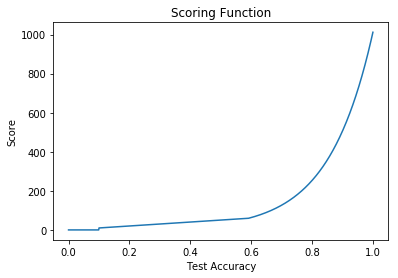

In [10]:
from exercise_code.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.59, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()